# Koopman Operator Theory in Foundational Robotics Research

The script will go through the main process of implementing the Koopman theory in robotic platforms for modeling and control. The example with a differential-drive robotic model is shown below. For each part, we only show the most common and simple way to illustrate the idea, please refer to the paper for more details,.

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def diff_drive_DT(x, u, Ts):
    # Define your differential drive model here
    return np.array([x[0] + u[0] * Ts * np.cos(x[2]),
                     x[1] + u[0] * Ts * np.sin(x[2]),
                     x[2] + u[1] * Ts])

def dictionary(xu, index_d):
    # Define your dictionary function here
    # psi_x = ...
    x = xu[:3]
    # u = xu[3:5]
    psi_x = np.concatenate((x, np.cos(x), np.sin(x)), axis=0)
    psi_x_u = np.concatenate((psi_x, xu[3:5]), axis=0)  # Append the control signal to the states
    return psi_x

## Section 1 Initialization
### 1.1 Select the proper state and input
In this example, we select the transitional position `x(m)`, `y(m)` and the rotational angle `theta(radian)` to be states, the right and left wheel velocities `v_r(radians/second)` and `v_l(radians/second)` to be inputs. 

In [21]:
nx = 3 # Number of states
nu = 2 # Number of inputs
n = nx + nu
Ts = 0.1 # Sampling rate
numTrainingData = 10000

### 1.2 Data Collection
In this example, we are going to show two way for data collection. 
For the first case, multiple different initial condition and input signals are selected and each of the pair is used to propagate the system for one step.

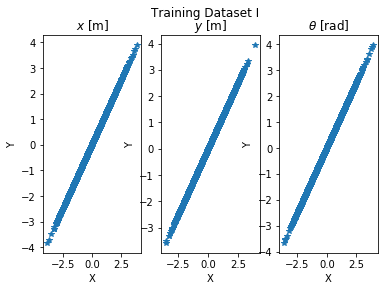

In [22]:
X = np.zeros((n, numTrainingData))
Y = np.zeros((n, numTrainingData))

mu_u = np.zeros((nu, numTrainingData))
sigma_u = 0.01 * np.ones((nu, numTrainingData))
mu_x = np.zeros((nx, numTrainingData))
sigma_x = np.ones((nx, numTrainingData))

input_rand = np.random.normal(mu_u, sigma_u)
initial_cond = np.random.normal(mu_x, sigma_x)

for i in range(numTrainingData):
    X[:, i] = np.concatenate((initial_cond[:, i], input_rand[:, i]))
    Y[:, i] = np.concatenate((diff_drive_DT(initial_cond[:, i], input_rand[:, i], Ts), np.zeros((nu,))))

# Plotting training dataset I
plt.figure(1)

plt.subplot(1, 3, 1)
plt.plot(X[0, :], Y[0, :], '*')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('$x$ [m]')

plt.subplot(1, 3, 2)
plt.plot(X[1, :], Y[1, :], '*')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('$y$ [m]')

plt.subplot(1, 3, 3)
plt.plot(X[2, :], Y[2, :], '*')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(r'$\theta$ [rad]')

plt.suptitle('Training Dataset I')
plt.show()

For the second case, each pair of initial condition and input signals is used to propagate the system continuously. Thus trajectories of measurements are collected.

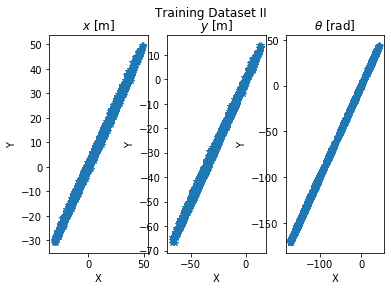

In [10]:
# Generate data for training dataset II
mu_u = np.zeros((nu, numTrainingData))
sigma_u = 10 * np.ones((nu, numTrainingData))
input_rand = np.random.normal(mu_u, sigma_u)
initial_condition = np.random.rand(nx, 1)

x_train = np.zeros((nx, numTrainingData + 1))
x_train[:, 0] = initial_condition.flatten()

for i in range(numTrainingData):
    x_train[:, i + 1] = diff_drive_DT(x_train[:, i], input_rand[:, i], Ts)

X = np.vstack((x_train[:, :-1], input_rand))
Y = np.vstack((x_train[:, 1:], np.zeros((nu, numTrainingData))))

# Plotting training dataset II
plt.figure(2)

plt.subplot(1, 3, 1)
plt.plot(X[0, :], Y[0, :], '*')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('$x$ [m]')

plt.subplot(1, 3, 2)
plt.plot(X[1, :], Y[1, :], '*')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('$y$ [m]')

plt.subplot(1, 3, 3)
plt.plot(X[2, :], Y[2, :], '*')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(r'$\theta$ [rad]')

plt.suptitle('Training Dataset II')
plt.show()

### 1.3 Dictionary Selection
Select the dictionary of lifting functions (observables)

In this example, we choose the dictionary of 30 fucntions consisting of the state vector, trigonometric function of the angle theta and their multiplications. The dictionary function is defined outside the main file for this example (as shown in the first cell). You can use the following template to specify your own dictionary of lifting functions. 

    function psi_x = dictionary(x,u)
        psi_x = []; # Note that it should be a vector of size 1*n
    end

In [29]:
index_d = 1

# Check how your dictionary performs.
x_example = np.random.rand(nx, 1)
u_example = np.random.rand(nu, 1)
psi_example = dictionary(np.concatenate((x_example, u_example)), index_d)
print(psi_example)

[[0.95789813]
 [0.27532556]
 [0.6509152 ]
 [0.57524055]
 [0.96233674]
 [0.7955296 ]
 [0.8179843 ]
 [0.27186025]
 [0.60591473]]


## Section 2 Koopman Operator Estimation
### 2.1 Approximate the Koopman oeprator with EDMD

In [31]:
sizeK = 9
G = np.zeros((sizeK, sizeK))
A = np.zeros((sizeK, sizeK))

for i in range(numTrainingData):
    # Lift the states using the selected dictionary
    x_psi = dictionary(X[:, i], index_d)
    y_psi = dictionary(Y[:, i], index_d)
    G += np.outer(x_psi, x_psi)
    A += np.outer(x_psi, y_psi)

G /= numTrainingData
A /= numTrainingData
K = np.linalg.pinv(G) @ A
sizeK = K.shape[0]
size_liftedx = sizeK - nu

C = np.zeros((nx, sizeK))
C[:nx, :nx] = np.eye(nx)  # Define the predictor matrix

### 2.2 check the prediction performance of the operator

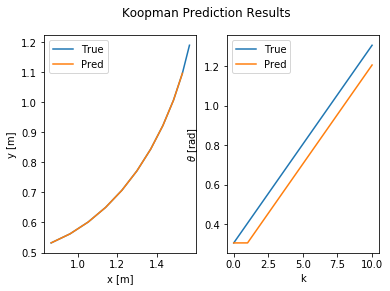

In [32]:
M_test = 10
x_test_pred = np.zeros((nx, M_test + 1))
x_test = np.zeros((nx, M_test + 1))
x_test_pred[:, 0] = np.random.rand(nx)
x_test[:, 0] = x_test_pred[:, 0]
u_test = np.array([1, 1])

for i in range(M_test):
    x_test[:, i + 1] = diff_drive_DT(x_test[:, i], u_test, Ts)
    x_test_pred[:, i + 1] = C @ K @ dictionary(np.concatenate((x_test[:, i], u_test)), index_d).T

# Plotting Koopman prediction results
plt.figure(3)

plt.subplot(1, 2, 1)
plt.plot(x_test[0, :], x_test[1, :])
plt.plot(x_test_pred[0, :], x_test_pred[1, :])
plt.legend(['True', 'Pred'])
plt.xlabel('x [m]')
plt.ylabel('y [m]')

plt.subplot(1, 2, 2)
plt.plot(x_test[2, :])
plt.plot(x_test_pred[2, :])
plt.xlabel('k')
plt.ylabel(r'$\theta$ [rad]')
plt.legend(['True', 'Pred'])

plt.suptitle('Koopman Prediction Results')
plt.show()

### 2.3 (Optional) Observe the Koopman eigenfunction, Koopman mode and Koopman eigenvalues

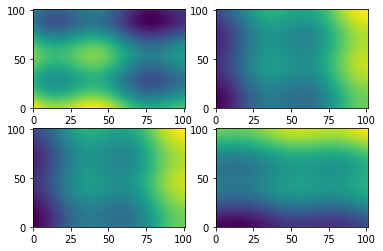

In [36]:
#  Calculate the Koopman eigenvalue lambda
from scipy import linalg
w  = linalg.eig(K, left=True, right=False)[1]
lam = linalg.eig(K, left=False, right=True)[0] # Koopman eigen values
xi = linalg.eig(K, left=False, right=True)[1]

x = np.arange(-5, 5.1, 0.1)
y = np.arange(-5, 5.1, 0.1)
theta = 0

for e_index in range(4):
    phi = np.zeros((len(x), len(y)))

    for i in range(len(x)):
        for j in range(len(y)):
            psi_x = dictionary([x[i], y[j], theta, 0, 0], index_d)
            phi[i, j] = np.real(np.dot(psi_x, xi[:, e_index]))

    # Plot the Koopman eigenfunctions
    plt.figure(4)
    plt.subplot(2, 2, e_index + 1)
    h = plt.pcolor(phi)
    h.set_edgecolor('none')

    # Calculate the Koopman Mode
    vi = np.dot(C, w[:, e_index])

## Section 3 Controller Design